In [ ]:
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import tensorflow as tf

from keras.preprocessing import image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

data_path= '/content/drive/My Drive/skin-disease-datasaet/train_set'

In [ ]:
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    file = os.listdir(folder_path)
    num_train = int(0.8 * len(file))
    files_train = random.sample(file, num_train)
    files_val = list(set(file) - set(files_train))

    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        train_data.append((img, folder))

    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        val_data.append((img, folder))

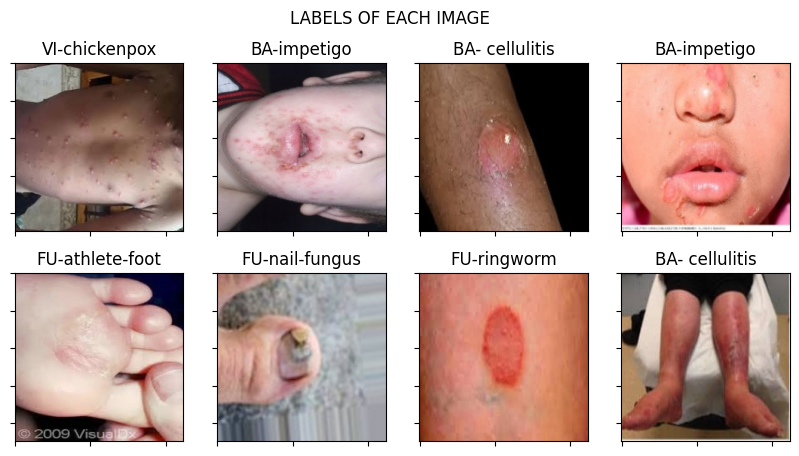

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(False)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )

plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# train_data = [(preprocess_input(input), label) for input, label in train_data]
# val_data = [(preprocess_input(input), label) for input, label in val_data]

X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)

In [ ]:
le.classes_

array(['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot',
       'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans',
       'VI-chickenpox', 'VI-shingles'], dtype='<U26')

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
base_model.trainable = False

In [ ]:

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
EPOCHS = 4
BATCH_SIZE = 32
history = model.fit(X_train, y_train_one_hot, validation_data=(X_val, y_val_one_hot),
                   epochs = EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/4
24/24 [==============================] - 204s 8s/step - loss: 1.0783 - accuracy: 0.6911 - val_loss: 0.4648 - val_accuracy: 0.8503
Epoch 2/4
24/24 [==============================] - 194s 8s/step - loss: 0.1249 - accuracy: 0.9607 - val_loss: 0.2804 - val_accuracy: 0.9198
Epoch 3/4
24/24 [==============================] - 196s 8s/step - loss: 0.0344 - accuracy: 0.9959 - val_loss: 0.2593 - val_accuracy: 0.9305
Epoch 4/4
24/24 [==============================] - 189s 8s/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 0.9305


In [ ]:

model.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.evaluate(X_train)

24/24 [==============================] - 0s 13ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [ ]:
test_loss, test_accuracy = model.evaluate(X_val)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

6/6 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test Accuracy: 0.00%


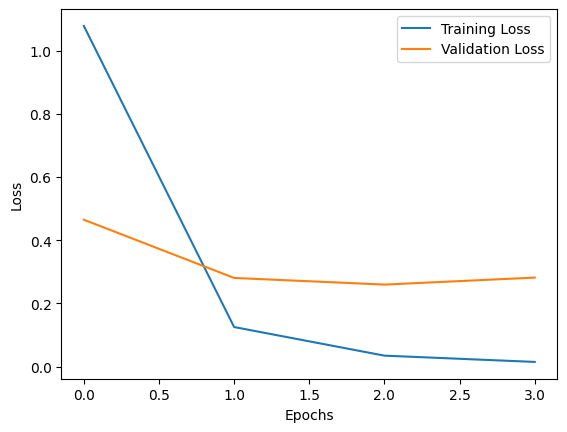

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

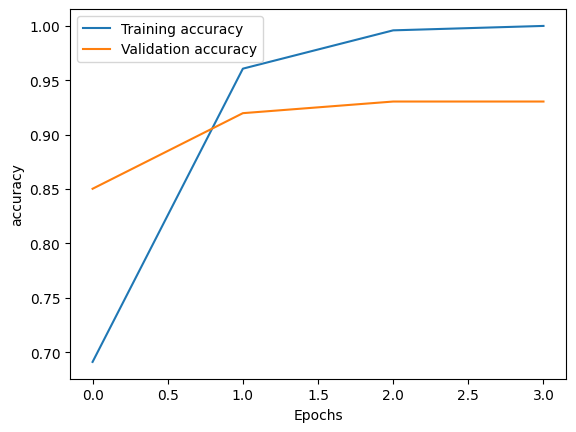

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:

test_path= '/content/drive/My Drive/skin-disease-datasaet/test_set'

In [ ]:
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224,224))
        img = preprocess_input(np.array([img]))
        predictions = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(predictions)
        predicted_class.append(le.classes_[predicted_class_index])

1/1 [==============================] - 0s 233ms/step


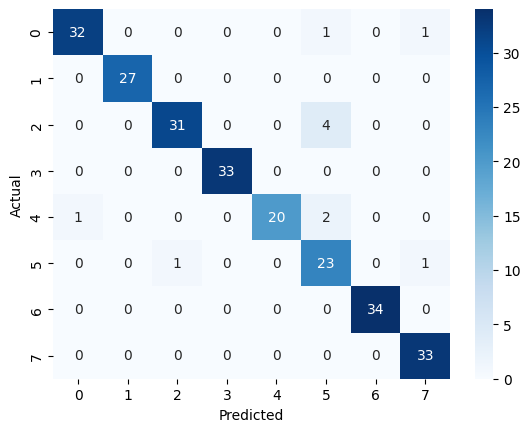

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(real_label, predicted_class)
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
img1=[]
l =[]
test_path= '/content/drive/My Drive/skin-disease-datasaet/test_set/'

for i in os.listdir(test_path):
  p = os.listdir(os.path.join(test_path,i))
  for path in p:
    img1.append(os.path.join(test_path , i , path))
    l.append(i)


In [ ]:
img1 = ['test5.jpg']

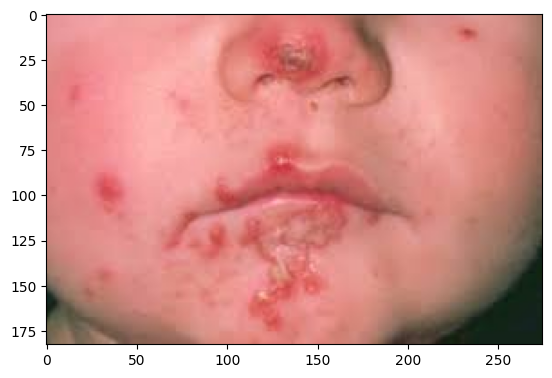

labels :  VI-chickenpox


In [ ]:
ind = 0
test_img = image.load_img(img1[ind])
plt.imshow(test_img)
plt.show()
print('labels : ',l[ind])

In [ ]:
img = cv2.imread(img1[ind])
img = cv2.resize(img, (224,224))
img = preprocess_input(np.array([img]))


In [ ]:

predictions = model.predict(img)
res = np.argmax(predictions)
predicted_class= le.classes_[res]

1/1 [==============================] - 0s 227ms/step


In [ ]:
predictions

array([[1.5204705e-09, 9.9998951e-01, 4.4153903e-09, 1.4202314e-07,
        3.2875198e-07, 7.8563562e-06, 5.4644448e-07, 1.6483327e-06]],
      dtype=float32)

In [ ]:
le.classes_

array(['BA- cellulitis', 'BA-impetigo', 'FU-athlete-foot',
       'FU-nail-fungus', 'FU-ringworm', 'PA-cutaneous-larva-migrans',
       'VI-chickenpox', 'VI-shingles'], dtype='<U26')

In [ ]:
predicted_class

'BA-impetigo'

In [ ]:
class Sample:

  k=10
  def mySort(self):
    print(self.k)
    print(k)
  def myDes(self):
    self.k=20
    print(self.k)
    print(k)

ob = Sample()
ob.mySort()
ob.myDes()
ob.mySort()

10
10
20
10
20
10


In [ ]:
f ='7'
f = f+'0'
e = int(f)+3
print(float(e))

73.0
